# Momo's Campaign Analytics


# INTRODUCTION
The aim of the campaign is to know if the different MoMo ages have different serviceid cluster, and how we do cross-sale to customers

## Data Description
- Servicedid: The identity of the transaction
- Date: the date that transaction is performed
- User_id: The identity of the individual customer
- Momo_age: the difference between LastServiceDate and FristServiceDate

## Result from the study
1.We would like to know whether users in different MoMo ages have different serviceid cluster?
- Customer in 100_Momo_age group tend to use Serviceid of 667, 333, 1014, 487, 981
- Customer in 200_Momo_age group tend to use Serviceid of 981, 20, 1014, 271, 666 
- Customer in 300_Momo_age group tend to use Serviceid of 18, 333, 667, 981, 268
- Customer in 300_plus_Momo_age group tend to use Serviceid of 981, 19, 271, 1014, 2

2.We would like to know which serviceid we can cross-sales to users?
- If a customer converts Serviceid_333, we suggest them the Serviceid_667 with Support of 20%, Confidence of 100%, Lift being greater than 1.
- If a customer converts Serviceid_667, we suggest them the Serviceid_333 with Support of 20%, Confidence of 91.8%, Lift being greater than 1.
- If a customer converts Serviceid_981, we suggest them the Serviceid_1014 with Support of 16.9%, Confidence of 61%, Lift being greater than 1.
- Do the same procedure for the rest of the table

# LIBRARY

In [1]:
# Data Processing
import numpy as np
import pandas as pd
import datetime as dt
import functools

# Data Visualizing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
from IPython.display import display, HTML
import plotly.express as px
import plotly.graph_objs as go
from IPython.display import display, HTML
from IPython.display import Image

# Data Clustering
from mlxtend.frequent_patterns import apriori # Data pattern exploration
from mlxtend.frequent_patterns import association_rules # Association rules conversion

# Data Modeling
from sklearn.ensemble import RandomForestRegressor

# Math
from scipy import stats  # Computing the t and p values using scipy 
from statsmodels.stats import weightstats 

# Warning Removal
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

# DATA EXPLORATION

In [7]:
df1 = pd.read_csv('../input/momo-data-process/data process.csv')
df2 = pd.read_csv('../input/momo-analytics1/Momo_Analytics.csv')

In [8]:
df1.rename(columns = {'user_id':'User_id'}, inplace=True)
df1.head()

,User_id,firstserviceid,secondserviceid,lastserviceid,firstservicedate,secondservicedate,lastservicedate,totalservice
0,11642209,20,983,666,2018-01-01,2018-01-02,2018-06-29,14
1,18246539,984,666,666,2018-03-22,2018-04-01,2018-04-01,4
2,20831230,667,1366,1366,2018-01-01,2018-02-08,2018-02-08,4
3,21307673,981,983,983,2018-01-03,2018-01-10,2018-07-27,10
4,2464231,18,982,982,2018-01-07,2018-01-16,2018-07-23,10


In [9]:
df2.head()

,Serviceid,Date,User_id
0,13,7-Jan-18,40750022
1,268,8-Jan-18,40750022
2,268,8-Jan-18,40750022
3,257,9-Jan-18,40750022
4,13,20-Jan-18,40750022


# ANALYSIS 1

## 1.We would like to know whether users in different MoMo ages  have different serviceid cluster?

In [10]:
dfs = [df1, df2]
CustomerTable = functools.reduce(lambda left,right: pd.merge(left,right,on='User_id', how='outer'), dfs)
CustomerTable.dropna(inplace=True)

In [11]:
CustomerTable.head()

,User_id,firstserviceid,secondserviceid,lastserviceid,firstservicedate,secondservicedate,lastservicedate,totalservice,Serviceid,Date
0,11642209,20.0,983.0,666.0,2018-01-01,2018-01-02,2018-06-29,14.0,20,1-Jan-18
1,11642209,20.0,983.0,666.0,2018-01-01,2018-01-02,2018-06-29,14.0,666,2-Jan-18
2,11642209,20.0,983.0,666.0,2018-01-01,2018-01-02,2018-06-29,14.0,326,2-Jan-18
3,11642209,20.0,983.0,666.0,2018-01-01,2018-01-02,2018-06-29,14.0,20,3-Jan-18
4,11642209,20.0,983.0,666.0,2018-01-01,2018-01-02,2018-06-29,14.0,326,9-Jan-18


In [12]:
CustomerTable['firstservicedate'] = pd.to_datetime(CustomerTable['firstservicedate'])
CustomerTable['secondservicedate'] = pd.to_datetime(CustomerTable['secondservicedate'])
CustomerTable['lastservicedate'] = pd.to_datetime(CustomerTable['lastservicedate'])
CustomerTable['Date'] = pd.to_datetime(CustomerTable['Date'])

In [13]:
CustomerTable.head()

,User_id,firstserviceid,secondserviceid,lastserviceid,firstservicedate,secondservicedate,lastservicedate,totalservice,Serviceid,Date
0,11642209,20.0,983.0,666.0,2018-01-01,2018-01-02,2018-06-29,14.0,20,2018-01-01
1,11642209,20.0,983.0,666.0,2018-01-01,2018-01-02,2018-06-29,14.0,666,2018-01-02
2,11642209,20.0,983.0,666.0,2018-01-01,2018-01-02,2018-06-29,14.0,326,2018-01-02
3,11642209,20.0,983.0,666.0,2018-01-01,2018-01-02,2018-06-29,14.0,20,2018-01-03
4,11642209,20.0,983.0,666.0,2018-01-01,2018-01-02,2018-06-29,14.0,326,2018-01-09


In [14]:
CustomerTable['Momo_age'] = 1 + (CustomerTable['lastservicedate']-CustomerTable['firstservicedate']).dt.days

In [15]:
# Split customers into 4 categories of 100_Momo_age, 200_Momo_age, 300_Momo_age, 300_plus_Momo_age

bins = [-1, 100, 200, 300, np.inf]
names = ['100_Momo_age', '200_Momo_age', '300_Momo_age', '300_plus_Momo_age']
CustomerTable['Momo_age_bin'] = pd.cut(CustomerTable['Momo_age'], bins, labels=names)

In [16]:
CustomerTable.head()

,User_id,firstserviceid,secondserviceid,lastserviceid,firstservicedate,secondservicedate,lastservicedate,totalservice,Serviceid,Date,Momo_age,Momo_age_bin
0,11642209,20.0,983.0,666.0,2018-01-01,2018-01-02,2018-06-29,14.0,20,2018-01-01,180,200_Momo_age
1,11642209,20.0,983.0,666.0,2018-01-01,2018-01-02,2018-06-29,14.0,666,2018-01-02,180,200_Momo_age
2,11642209,20.0,983.0,666.0,2018-01-01,2018-01-02,2018-06-29,14.0,326,2018-01-02,180,200_Momo_age
3,11642209,20.0,983.0,666.0,2018-01-01,2018-01-02,2018-06-29,14.0,20,2018-01-03,180,200_Momo_age
4,11642209,20.0,983.0,666.0,2018-01-01,2018-01-02,2018-06-29,14.0,326,2018-01-09,180,200_Momo_age


In [17]:
CustomerTable.groupby(['Momo_age_bin','Serviceid'])[['User_id']].count().dropna()

User_id
Momo_age_bin      Serviceid         
100_Momo_age      11             1.0
                  12             1.0
                  13             8.0
                  18             4.0
                  19             1.0
...                              ...
300_plus_Momo_age 271            9.0
                  398            1.0
                  487            3.0
                  981           14.0
                  1014           8.0

[141 rows x 1 columns]

#### Observation
- Customer in 100_Momo_age group tend to use Serviceid of 667, 333, 1014, 487, 981
- Customer in 200_Momo_age group tend to use Serviceid of 981, 20, 1014, 271, 666 
- Customer in 300_Momo_age group tend to use Serviceid of 18, 333, 667, 981, 268
- Customer in 300_plus_Momo_age group tend to use Serviceid of 981, 19, 271, 1014, 2

In [18]:
# Grouping customers bases on categories of Momo_age_bin and servicedid, 
# in order to know which services were used most by each segment
CustomerAgg = CustomerTable.groupby(['Momo_age_bin','Serviceid'])[['User_id']].count().dropna()

# Source: https://stackoverflow.com/questions/27842613/pandas-groupby-sort-within-groups
# We group by the first level of the index:
g = CustomerAgg['User_id'].groupby(level=0, group_keys=False)

# Then we want to sort 'order' each group and take the first five elements:
# Alternative:  res = g.apply(lambda x: x.order(ascending=False).head(5))
g.nlargest(5)

Momo_age_bin       Serviceid
100_Momo_age       667           37.0
                   333           36.0
                   1014          21.0
                   487           18.0
                   981           17.0
200_Momo_age       981           99.0
                   20            75.0
                   1014          65.0
                   271           64.0
                   666           49.0
300_Momo_age       18           129.0
                   333           74.0
                   667           74.0
                   981           67.0
                   268           51.0
300_plus_Momo_age  981           14.0
                   19            10.0
                   271            9.0
                   1014           8.0
                   2              4.0
Name: User_id, dtype: float64

## 2. We would like to know which serviceid we can cross-sales to users?

In [19]:
# CrossSale: https://www.youtube.com/watch?v=VMavY0pBo2o
CustomerTable.head()

,User_id,firstserviceid,secondserviceid,lastserviceid,firstservicedate,secondservicedate,lastservicedate,totalservice,Serviceid,Date,Momo_age,Momo_age_bin
0,11642209,20.0,983.0,666.0,2018-01-01,2018-01-02,2018-06-29,14.0,20,2018-01-01,180,200_Momo_age
1,11642209,20.0,983.0,666.0,2018-01-01,2018-01-02,2018-06-29,14.0,666,2018-01-02,180,200_Momo_age
2,11642209,20.0,983.0,666.0,2018-01-01,2018-01-02,2018-06-29,14.0,326,2018-01-02,180,200_Momo_age
3,11642209,20.0,983.0,666.0,2018-01-01,2018-01-02,2018-06-29,14.0,20,2018-01-03,180,200_Momo_age
4,11642209,20.0,983.0,666.0,2018-01-01,2018-01-02,2018-06-29,14.0,326,2018-01-09,180,200_Momo_age


In [20]:
Cross_sale = CustomerTable[['User_id', 'Date', 'Serviceid']]
Cross_sale['User_id & Date'] = Cross_sale['User_id'].astype('str') + ' ' + Cross_sale['Date'].astype('str')
Cross_sale.drop(['User_id', 'Date'], axis=1, inplace=True)

In [21]:
# To eliminate duplicate rows. For example, a customer use 1 particular serviceid twice a day, 
# all we need is to know the number of unique serviceids per day for each customer.
# Another example, a customer usually buy 2 toothbrushes along with 1 toothpaste. Thus, we can cross-sell 2-item combo.
Cross_sale.drop_duplicates(inplace = True)

In [22]:
Cross_sale.set_index('User_id & Date', inplace=True)

In [23]:
Cross_sale.head(10)

,Serviceid
User_id & Date,
11642209 2018-01-01,20
11642209 2018-01-02,666
11642209 2018-01-02,326
11642209 2018-01-03,20
11642209 2018-01-09,326
11642209 2018-01-09,20
11642209 2018-01-09,666
11642209 2018-01-11,326
11642209 2018-01-11,20


In [24]:
Cross_sale['Serviceid'] = Cross_sale['Serviceid'].astype('str')

basket = pd.get_dummies(Cross_sale)
basket.head()

,Serviceid_10,Serviceid_1014,Serviceid_1046,Serviceid_1086,Serviceid_11,Serviceid_1136,Serviceid_1166,Serviceid_1186,Serviceid_12,Serviceid_125,...,Serviceid_82,Serviceid_904,Serviceid_905,Serviceid_91,Serviceid_946,Serviceid_981,Serviceid_982,Serviceid_983,Serviceid_984,Serviceid_985
User_id & Date,,,,,,,,,,,,,,,,,,,,,
11642209 2018-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11642209 2018-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11642209 2018-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11642209 2018-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11642209 2018-01-09,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
basket_sets = pd.pivot_table(basket, index='User_id & Date', aggfunc='sum')
basket_sets

,Serviceid_10,Serviceid_1014,Serviceid_1046,Serviceid_1086,Serviceid_11,Serviceid_1136,Serviceid_1166,Serviceid_1186,Serviceid_12,Serviceid_125,...,Serviceid_82,Serviceid_904,Serviceid_905,Serviceid_91,Serviceid_946,Serviceid_981,Serviceid_982,Serviceid_983,Serviceid_984,Serviceid_985
User_id & Date,,,,,,,,,,,,,,,,,,,,,
11642209 2018-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11642209 2018-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11642209 2018-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11642209 2018-01-09,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11642209 2018-01-11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958104 2018-03-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4958104 2018-03-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4958104 2018-03-11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
frequent_itemsets = apriori(basket_sets, min_support=0.03, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.212880,(Serviceid_1014),1
1,0.094812,(Serviceid_13),1
2,0.212880,(Serviceid_18),1
3,0.132379,(Serviceid_20),1
4,0.123435,(Serviceid_268),1
5,0.125224,(Serviceid_271),1
6,0.030411,(Serviceid_273),1
7,0.032200,(Serviceid_299),1
8,0.101968,(Serviceid_326),1
9,0.200358,(Serviceid_333),1


In [27]:
# Advanced and strategical data frequent set selection
frequent_itemsets[ (frequent_itemsets['length'] > 1) &
                   (frequent_itemsets['support'] >= 0.02)]

,support,itemsets,length
16,0.060823,"(Serviceid_1014, Serviceid_18)",2
17,0.169946,"(Serviceid_1014, Serviceid_981)",2
18,0.073345,"(Serviceid_13, Serviceid_333)",2
19,0.073345,"(Serviceid_13, Serviceid_667)",2
20,0.075134,"(Serviceid_18, Serviceid_268)",2
21,0.033989,"(Serviceid_271, Serviceid_18)",2
22,0.096601,"(Serviceid_981, Serviceid_18)",2
23,0.076923,"(Serviceid_18, Serviceid_982)",2
24,0.059034,"(Serviceid_20, Serviceid_326)",2
25,0.059034,"(Serviceid_20, Serviceid_666)",2


### Observations:
- If a customer converts Serviceid_333, we suggest them the Serviceid_667 with Support of 20%, Confidence of 100%, Lift being greater than 1.
- If a customer converts Serviceid_667, we suggest them the Serviceid_333 with Support of 20%, Confidence of 91.8%, Lift being greater than 1.
- If a customer converts Serviceid_981, we suggest them the Serviceid_1014 with Support of 16.9%, Confidence of 61%, Lift being greater than 1.
- Do the same with the following rows.
- Further explaination: https://towardsdatascience.com/association-rules-2-aa9a77241654

In [28]:
# Generating the association_rules: rules
# Selecting the important parameters for analysis
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values('support', ascending=False).head()

,antecedents,consequents,support,confidence,lift
26,(Serviceid_333),(Serviceid_667),0.200358,1.000000,4.581967
27,(Serviceid_667),(Serviceid_333),0.200358,0.918033,4.581967
2,(Serviceid_1014),(Serviceid_981),0.169946,0.798319,2.897795
3,(Serviceid_981),(Serviceid_1014),0.169946,0.616883,2.897795
20,(Serviceid_982),(Serviceid_268),0.114490,0.984615,7.976812


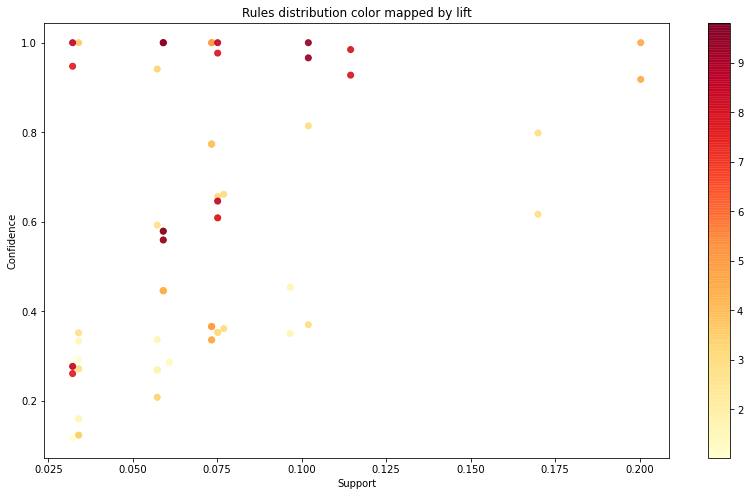

In [29]:
# Visualizing the rules distribution color mapped by Lift
plt.figure(figsize=(14, 8))
plt.scatter(rules['support'], rules['confidence'], c=rules['lift'], alpha=0.9, cmap='YlOrRd');
plt.title('Rules distribution color mapped by lift');
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.colorbar();